$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$


This notebook demonstrate the principal functionalities of pbdlib.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pbdlib as pbd
from pprint import pprint as print # for pretty printing

%matplotlib inline
%load_ext autoreload
%autoreload 2

from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

2023-03-10 13:15:59.518595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 13:15:59.626032: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 13:15:59.626045: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-10 13:16:00.161553: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Multivariate Normal Distribution (MVN) - Gaussian
Here we create a multivariate Gaussian distribution, plot it, transform it and make product.


## Transformation  
We demonstrate how to transform MVN distributions. Suppose that the distribution acts on transformed datapoint $\bm{x}$ as $\mathcal{N}(\bm{A}\bm{x} + \bm{b}|\, \bm{\mu}, \bm{\Sigma})$. This distribution can be expressed on the original data point by transforming the parameters $\bm{\mu}, \bm{\Sigma}$ instead :

$$\mathcal{N}(\bm{A}\bm{x} + \bm{b}|\, \bm{\mu}, \bm{\Sigma}) = \mathcal{N}(\bm{x} |\, \bm{\mu}_{transf}, \bm{\Sigma}_{transf})$$
with

$$\bm{\mu}_{transf} = \bm{A}^\dagger (\bm{\mu}-\bm{b})$$
$$\bm{\Lambda}_{transf} = \bm{A}^\trsp\bm{\Lambda} \bm{A}$$
$$\bm{\Sigma}_{transf} = \bm{\Lambda}_{transf}^{-1}$$

see [Liu](http://www.cs.columbia.edu/~liulp/pdf/linear_normal_dist.pdf) for more precision. **WARNING** The transformation here are not the same as in the paper, they are the inverse.

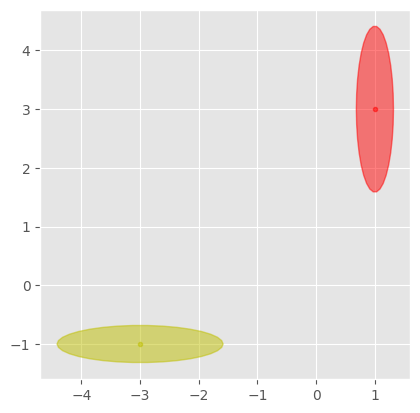

In [2]:
# create distribution
mvn = pbd.MVN(mu=np.array([1., 3.]), sigma=np.diag([0.1, 2.]))

# plot distribution
plt.axes().set_aspect('equal')
pbd.plot_gmm(mvn.mu, mvn.sigma) 

# transformation
rot_mat = pbd.utils.angle_to_rotation(np.pi/2)  # create rotation matrix from angle
mvn = mvn.transform(A=rot_mat, b=np.array([0., -2.]))  # apply the transformation on the distribution
pbd.plot_gmm(mvn.mu, mvn.sigma, color='y');

## Product 

Suppose we want to combine evidences from multiples experts, whose belief is expressed as probability distributions with parameters $\bm{\theta}^{(j)}$ for expert $j$. One way to combine this distribution to get the best agreement between the expert is to make the product of them, see [Hinton](http://www.cs.toronto.edu/~hinton/absps/nccd.pdf).
\begin{equation}
p(\bm{\xi}_t|\bm{\theta}^{(1)}, \ldots, \bm{\theta}^{(P)}) = 
\frac{\prod_j p_j(\bm{\xi}_t\,| \bm{\theta}^{(j)})}
{\int_x \prod_j p_j(\bm{x}\,| \bm{\theta}^{(j)})}
\end{equation}

If the expert distributions are Gaussian with $\bm{\theta}^{(j)}=\{\bm{\mu}^{(j)}, \bm{\Sigma}^{(j)}\}$, the product as an analytical solution and is Gaussian as well. With  
$\bm{\Lambda} = \bm{\Sigma}^{-1}$

$\bm{\Lambda} = \sum_j {\bm{\Lambda}}^{(j)}$

$\bm{\mu} = \bm{\Lambda}^{-1 }\sum_j {\bm{\Lambda}}^{(j)} {\bm{\mu}}^{(j)}$

See [Bromiley](http://www.tina-vision.net/docs/memos/2003-003.pdf) for more precision.

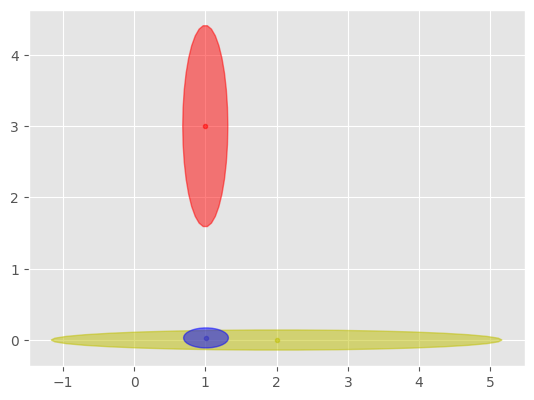

In [3]:
mvn = pbd.MVN(mu=np.array([1., 3.]), sigma=np.diag([0.1, 2.]))
mvn_2 = pbd.MVN(mu=np.array([2., 0.]), sigma=np.diag([10., 0.02]))

mvn_product = mvn * mvn_2
plt.axes().set_aspect('equal')

pbd.plot_gmm(mvn.mu, mvn.sigma)
pbd.plot_gmm(mvn_2.mu, mvn_2.sigma, color='y')

pbd.plot_gmm(mvn_product.mu, mvn_product.sigma, color='b');

# Gaussian Mixture Model (GMM)
This is an example on how to create a Gaussian Mixture model and train it over some data.

In [4]:
from scipy.io import loadmat # loading data from matlab

letter = 'C' # choose a letter in the alphabet
datapath = os.path.dirname(pbd.__file__) + '/data/2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)
demos = [d['pos'][0][0].T for d in data['demos'][0]] # cleaning awful matlab data

0.001


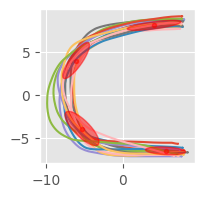

In [5]:
model = pbd.GMM(nb_dim=2, nb_states=4)

data = np.concatenate(demos)
model.em(data=data, reg=1e-3)

plt.figure(figsize=(2,2))
for p in demos:
    plt.plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma);

# Hidden Markov Model (HMM)

0.001
EM did not converge


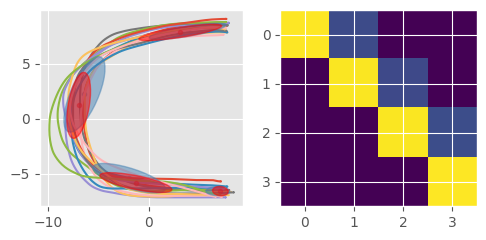

In [6]:
model = pbd.HMM(nb_states=4, nb_dim=2)

model.init_hmm_kbins(demos) # initializing model

# plotting
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(5,2.5)
pbd.plot_gmm(model.mu, model.sigma, alpha=0.5, color='steelblue', ax=ax[0]); # plot after init only

# EM to train model
model.em(demos, reg=1e-3) 

# plotting demos
for p in demos:
    ax[0].plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0]); 

# plotting transition matrix
ax[1].imshow(np.log(model.Trans+1e-10), interpolation='nearest', vmin=-5, cmap='viridis');
plt.tight_layout()

#### Compute most likely sequence of state with Viterbi and forward variable

14


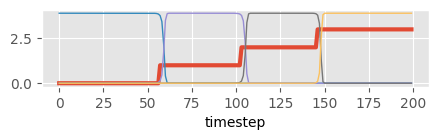

In [13]:
q = model.viterbi(demos[1])
print(demos[1].shape, len(demos))
alpha, _, _, _, _ = model.compute_messages(demos[1])

plt.figure(figsize=(5, 1))
plt.plot(q, lw=3);
plt.plot(alpha.T * (model.nb_states-0.1), lw=1);
plt.xlabel('timestep');

#### Compute likelihood of HMM model for given demo
This can be used for action recognition when considering multiple HMMs corresponding to different actions.

In [8]:
score = model.score(demos)
print(score)

[604.6126291210749,
 615.4742325655293,
 676.9734162587173,
 628.3800469230059,
 692.0712916907952,
 676.7349470271587,
 706.0265046373037,
 757.6929194837966,
 639.1831857827864,
 627.6829986051362,
 639.7431497857076,
 636.7105802407549,
 670.0450601922863,
 634.3556249319652]
